In [1]:
import wandb
import torch
import sklearn
import numpy as np
import pandas as pd
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from simpletransformers.classification import MultiLabelClassificationModel, MultiLabelClassificationArgs

In [2]:
# see GPU avaialability
cuda_available = torch.cuda.is_available()

% PER CLASS:

 SDG1      4.688020
SDG2      2.671225
SDG3      6.316593
SDG4      7.484520
SDG5     15.656094
SDG6      1.353229
SDG7      0.324279
SDG8     10.893040
SDG9      0.559170
SDG10    10.140086
SDG11     2.903506
SDG12     0.972185
SDG13     0.999589
SDG14     0.289046
SDG15     0.373215
SDG16    28.618779
SDG17     5.757424
dtype: float64


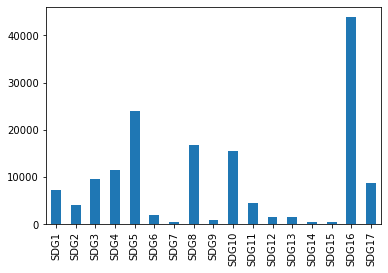

In [3]:
# import data
data = pd.read_csv('OneHot_Combined_cln_utf8.tsv', sep='\t')
# data = data.iloc[-1000:,:]
# reformat data
sdg_lst = ['SDG1','SDG2','SDG3','SDG4','SDG5','SDG6','SDG7','SDG8','SDG9','SDG10','SDG11','SDG12','SDG13','SDG14','SDG15','SDG16','SDG17']
data['y'] = data[sdg_lst].values.tolist()
y = data['y']
X = data['abstract']

# plot ratio of data
class_weight = (data[sdg_lst].sum()/ data[sdg_lst].sum().sum())
print('% PER CLASS:\n\n', class_weight*100)
data[sdg_lst].sum().plot.bar()

# split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# add data to dataframes
train_df = pd.DataFrame()
train_df['text'] = X_train
train_df['labels'] = y_train
train_df.reset_index(inplace=True, drop=True)

eval_df = pd.DataFrame()
eval_df['text'] = X_val
eval_df['labels'] = y_val
eval_df.reset_index(inplace=True, drop=True)

# get number of classes
label_count = len(sdg_lst)

In [4]:
# parameter optimisation
sweep_config = {
    "method": "bayes",  # bayes, grid, random
    "metric": {"name": "accuracy", "goal": "maximize"},
    "parameters": {
        "num_train_epochs": {"min": 1, "max": 20},
        "learning_rate": {"min": 5e-5, "max": 4e-4},
        "train_batch_size":{"min": 1, "max": 30},
        "eval_batch_size":{"min": 1, "max": 30},
        "warmup_steps":{"min": 50, "max": 500},
        "weight_decay":{"min": 0.01, "max": 0.1},
        # "logging_steps":{"min": 1, "max": 20}, #{"values": [2, 5, 10]}
        "threshold":{"min":0.0, "max":1.0}
    },
}

sweep_id = wandb.sweep(sweep_config, entity='sasdghub', project="sasdghub_ml_classify")

# logging
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

Create sweep with ID: vwbrqvdg
Sweep URL: https://wandb.ai/sasdghub/sasdghub_ml_classify/sweeps/vwbrqvdg


In [5]:
def acc_result(true, pred):
    true=np.argmax(true, axis=1)
    pred=np.argmax(pred, axis=1)
    acc = sklearn.metrics.accuracy_score(true, pred)
    return acc

def f1_macro_result(true, pred):
    true=np.argmax(true, axis=1)
    pred=np.argmax(pred, axis=1)
    f1 = sklearn.metrics.f1_score(true, pred, average='macro')
    return f1

def f1_micro_result(true, pred):
    true=np.argmax(true, axis=1)
    pred=np.argmax(pred, axis=1)
    f1 = sklearn.metrics.f1_score(true, pred, average='micro')
    return f1

def cm_result(true, pred):
    true=np.argmax(true, axis=1)
    pred=np.argmax(pred, axis=1)
    cm = wandb.plot.confusion_matrix(probs=None, y_true=true, preds=pred, class_names=sdg_lst) #sklearn.metrics.multilabel_confusion_matrix(true, pred)
    return cm

In [ ]:
# Optional model configuration
model_args = MultiLabelClassificationArgs(fp16= False,
                                          manual_seed = 4,
                                          use_multiprocessing = True,
                                          overwrite_output_dir=True,
                                          evaluate_during_training = True,
                                          # save_model_every_epoch = False, #
                                          # save_steps=-1, #
                                          # sliding_window=True, #
                                          #  Sliding window technique is not currently implemented for multi-label classification evaluation
                                          # wandb_project = 'sasdghub_ml_classify',
                                          # wandb_kwargs={
                                          #     'entity':'sasdghub'
                                          #              },
                                          # num_train_epochs=1,
                                          # train_batch_size= 16,
                                          # eval_batch_size= 64,
                                          # warmup_steps= 500,
                                          # weight_decay= 0.01,
                                          # logging_steps= 10,
                                          # learning_rate= 5e-5
                                          
                                         )

def train():
    
    # Initialize a new wandb run 
    wandb.init()

    # Create a MultiLabelClassificationModel
    model = MultiLabelClassificationModel(
        "xlnet",
        "xlnet-base-cased",
        num_labels=label_count,
        args=model_args,
        use_cuda=cuda_available,
        pos_weight=list((1/label_count)/class_weight),
        # show_running_loss=True,
        sweep_config=wandb.config,
    )
    
    print(model.get_named_parameters())
    
    # Train the model
    model.train_model(train_df,
                      verbose=True,
                      eval_df=eval_df,
                      accuracy=acc_result,
                      f1_macro=f1_macro_result,
                      f1_micro=f1_micro_result,
                      cm=cm_result)
    
    # Evaluate the model
    result, model_outputs, wrong_predictions = model.eval_model(
        eval_df,
        verbose=True,
        accuracy=acc_result,
        f1_macro=f1_macro_result,
        f1_micro=f1_micro_result,
        cm=cm_result
    )
    
    # Sync wandb
    wandb.join()
    
wandb.agent(sweep_id, train)

INFO:wandb.agents.pyagent:Starting sweep agent: entity=None, project=None, count=None
wandb: Agent Starting Run: 0rzr0e40 with config:
wandb: 	eval_batch_size: 1
wandb: 	learning_rate: 9.914451124319372e-05
wandb: 	num_train_epochs: 14
wandb: 	threshold: 0.2007065236579696
wandb: 	train_batch_size: 30
wandb: 	warmup_steps: 60
wandb: 	weight_decay: 0.023027082261374524
wandb: Currently logged in as: christopher-marais (sasdghub). Use `wandb login --relogin` to force relogin


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'logits_proj.weight', 'logits_proj.bias', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream tas

['transformer.mask_emb', 'transformer.word_embedding.weight', 'transformer.layer.0.rel_attn.q', 'transformer.layer.0.rel_attn.k', 'transformer.layer.0.rel_attn.v', 'transformer.layer.0.rel_attn.o', 'transformer.layer.0.rel_attn.r', 'transformer.layer.0.rel_attn.r_r_bias', 'transformer.layer.0.rel_attn.r_s_bias', 'transformer.layer.0.rel_attn.r_w_bias', 'transformer.layer.0.rel_attn.seg_embed', 'transformer.layer.0.rel_attn.layer_norm.weight', 'transformer.layer.0.rel_attn.layer_norm.bias', 'transformer.layer.0.ff.layer_norm.weight', 'transformer.layer.0.ff.layer_norm.bias', 'transformer.layer.0.ff.layer_1.weight', 'transformer.layer.0.ff.layer_1.bias', 'transformer.layer.0.ff.layer_2.weight', 'transformer.layer.0.ff.layer_2.bias', 'transformer.layer.1.rel_attn.q', 'transformer.layer.1.rel_attn.k', 'transformer.layer.1.rel_attn.v', 'transformer.layer.1.rel_attn.o', 'transformer.layer.1.rel_attn.r', 'transformer.layer.1.rel_attn.r_r_bias', 'transformer.layer.1.rel_attn.r_s_bias', 'transf

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/63940 [00:00<?, ?it/s]

wandb: Network error (ConnectionError), entering retry loop.


In [ ]:
# train with optimal parameters
# # logging
# logging.basicConfig(level=logging.INFO)
# transformers_logger = logging.getLogger("transformers")
# transformers_logger.setLevel(logging.WARNING)

# # Optional model configuration
# model_args = MultiLabelClassificationArgs(fp16= False,
#                                           threshold=0.8,
#                                           manual_seed = 4,
#                                           use_multiprocessing = True,
#                                           overwrite_output_dir=True,
#                                           evaluate_during_training = True,
#                                           wandb_project = 'sasdghub_ml_classify',
#                                           wandb_kwargs={
#                                               'entity':'sasdghub'
#                                                        },
#                                           num_train_epochs=1,
#                                           train_batch_size= 16,
#                                           eval_batch_size= 64,
#                                           warmup_steps= 500,
#                                           weight_decay= 0.01,
#                                           logging_steps= 10,
#                                           learning_rate= 5e-5
                                          
#                                          )

# # Create a MultiLabelClassificationModel
# model = MultiLabelClassificationModel(
#     "xlnet",
#     "xlnet-base-cased",
#     num_labels=label_count,
#     args=model_args,
#     use_cuda=cuda_available,
#     pos_weight=list(1-class_weight),
    # show_running_loss=True,
    # sweep_config=wandb.config,
# )

# # Train the model
# model.train_model(train_df,
#                   verbose=True,
#                   eval_df=eval_df)

# # Evaluate the model
# result, model_outputs, wrong_predictions = model.eval_model(
#     eval_df,
#     verbose=True,
# )

In [ ]:
# Make predictions with the model
# predictions, raw_outputs = model.predict(["sanitation and clean drinking water"])

#######################################################################################


modify so it can digest longer text (split training data into paragraphs that can be digested) # needs an update

freeze number of layers as a parameter

select and save best model
apply new model in apply script

make testing script with ROC curves and confusion matrices (model.eval)

make testing dataset and train real classifier

get model embedding
train classifier for targets
OR
force nodes for each SDG to output only to targets (SDG7 node does not link to target 9.5 but only to 7.x targets.) (heirarichical classification NN)